# 通过 SageMaker 分割人口

在此 notebook 中，你将利用两个非监督式学习算法进行**人口分割**。人口分割旨在查找人口数据中的自然分组，并体现出美国不同区域之间的特征级相似性。

你将利用**主成分分析** (PCA) 降低原始人口数据的维度。然后，你将利用 **K 均值聚类**根据郡县在成分空间里所处的位置将每个美国郡县分配到特定的聚类。每个聚类在成分空间里的排列方式可以告诉我们哪些美国郡县最相似，以及什么样的人口特征定义了这种相似性。这种信息通常用于目标市场营销活动，希望能吸引特定的人群。这类信息还可以展现我们平常不会注意到的区域之间的规律，有助于详细了解某个人群。

### 美国人口普查数据

你将使用[美国人口普查数据](https://en.wikipedia.org/wiki/United_States_Census)，该数据集计算了美国人口数量，记录了关于美国每个郡县的劳动力、年龄等人口特征。此 notebook 的大部分内容都摘自现有的 SageMaker 实例 notebook 和此[博文](https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/)，我将其进一步划分成了演示和要完成的练习。

### 机器学习工作流程

为了分割人口，你需要完成以下步骤：
* 加载和探索数据
* 清理和预处理数据
* 通过 PCA 降维
* 特征工程和数据转换
* 通过 K 均值进行聚类转换
* 提取训练过的模型属性并可视化 K 聚类

这些任务组成了完整的机器学习工作流程，从数据加载和清理到模型部署。每道练习都旨在让你实践机器学习工作流程的某个环节，并展示了如何使用 SageMaker 工具，例如使用 S3 的内置数据管理功能和内置算法。

---

首先，将相关库导入到此 SageMaker notebook 中。

In [1]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

In [2]:
# sagemaker libraries
import boto3
import sagemaker

## 从 Amazon S3 加载数据

这个数据集已经在 Amazon S3 存储桶中，你可以通过指向此存储桶加载数据，并按照名称获取数据文件。

> 你可以使用 `boto3` 客户端与 S3 交互。

In [3]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
bucket_name='aws-ml-blog-sagemaker-census-segmentation'

请查看此存储桶中的内容；获取存储桶中的对象列表，并输出对象的名称。你应该会看到一个叫做“Census_Data_for_SageMaker.csv”的文件。

In [4]:
# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

# print object(s)in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
print(files)

['Census_Data_for_SageMaker.csv']


In [5]:
# there is one file --> one key
file_name=files[0]

print(file_name)

Census_Data_for_SageMaker.csv


通过调用 `client.get_object()` 从存储桶中获取数据文件。

In [6]:
# get an S3 object by passing in the bucket and file name
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

# what info does the object contain?
display(data_object)

{'ResponseMetadata': {'RequestId': '8291EFA382ABA09D',
  'HostId': 'r6zmXjd6jbEYt3xY/V6pkrCs+4V56y7QUfRF7Cn5oa5N+nn3u2pZDYVMqbG1ba4UBJsxDFrPNKA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'r6zmXjd6jbEYt3xY/V6pkrCs+4V56y7QUfRF7Cn5oa5N+nn3u2pZDYVMqbG1ba4UBJsxDFrPNKA=',
   'x-amz-request-id': '8291EFA382ABA09D',
   'date': 'Thu, 16 Apr 2020 11:59:06 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '613237',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7fc60caacd68>}

In [7]:
# information is in the "Body" of the object
data_body = data_object["Body"].read()
print('Data type: ', type(data_body))

Data type:  <class 'bytes'>


这是 `bytes` 类型的数据，你可以使用 [io.BytesIO(file)](https://docs.python.org/3/library/io.html#binary-i-o) 读取该类型的数据。

In [8]:
# read in bytes data
data_stream = io.BytesIO(data_body)

# create a dataframe
counties_df = pd.read_csv(data_stream, header=0, delimiter=",") 
counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


## 探索性数据分析 (EDA)

加载了数据后，下面清理、探索和预处理数据。数据探索是最重要的机器学习工作流程环节之一，因为可以发现数据分布和特征的初始规律，并告诉我们如何开始建模和聚类数据。

### 练习：探索数据和删除任何不完整的数据行

第一次探索数据时，有必要了解下要处理的是什么样的数据。有多少数据点和特征？看一眼就能得出什么样的信息？在此 notebook 中，你需要使用完整的数据点训练模型。所以，第一个练习是研究数据的形状，并执行简单的数据清理步骤：删除任何不完整的数据行。

你应该能够回答以下**问题**：提供的原始数据集有多少个数据点和特征（删除所有不完整的行后，有多少数据点？）

In [9]:
# print out stats about data
print(np.size(counties_df))

# drop any incomplete rows of data, and create a new df
clean_counties_df = counties_df.dropna(axis=0)


119140


### 练习：创建新的 DataFrame，以“State-County”为索引

最终，你需要将这些特征传入机器学习模型中。机器学习模型需要使用数值数据，而不是字符串等类别数据（State、County）。所以需要转换数据，并按照区域设定索引，删除所有对聚类没有用的特征。

为了完成此任务，请使用在上面生成的清理后 DataFrame 执行以下步骤：
1. 将描述性列“State”和“County”合并成一个新的类别列“State-County”。
2. 根据唯一的“State-County”名称对数据设定索引。
3. 然后，删除之前的 State 和 County 列以及 CensusId 列，因为该列不能提供任何有意义的人口信息。

完成此任务后，你应该会获得一个以“State-County”列为索引的 DataFrame，并且每个郡县有 34 列数值数据。生成的 DataFrame 应该如下所示（为了便于显示，已经截断了一些数据）：
```
                TotalPop	 Men	  Women	Hispanic	...
                
Alabama-Autauga	55221	 26745	28476	2.6         ...
Alabama-Baldwin	195121	95314	99807	4.5         ...
Alabama-Barbour	26932	 14497	12435	4.6         ...
...

```

In [10]:
# index data by 'State-County'
# clean_counties_df.index= # your code here
clean_counties_df.index = clean_counties_df["State"] + "-" + clean_counties_df["County"]

In [11]:
# drop the old State and County columns, and the CensusId column
# clean df should be modified or created anew
clean_counties_df = clean_counties_df.drop(columns=["State", "County", "CensusId"])


你需要使用什么特征？

In [12]:
# features
features_list = clean_counties_df.columns.values
print('Features: \n', features_list)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


In [13]:
clean_counties_df.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


## 可视化数据

一般特征有各种范围，通常百分比是 0-100，计数是范围很大的整数值。我们可视化下某些特征列里的数据，看看所有郡县是什么样的分布。

以下单元格会显示**直方图**，展示了数据点在离散特征范围内的分布图。x 轴表示不同的区间；每个区间由特征可以采用的值范围确定，例如值 0-5 和 5-10，等等。y 轴表示郡县数据点落入每个区间的数量。我发现 y 轴可以用来在不同的特征之间进行比较。

下面我绘制了一个直方图，展示了所有郡县的通勤方法比较情况。我直接从上面输出的列名称列表中复制了这些特征名称。我还知道，所有这些特征在原始数据中用百分比 (%) 表示，所以这些图形的 x 轴是可比较的。

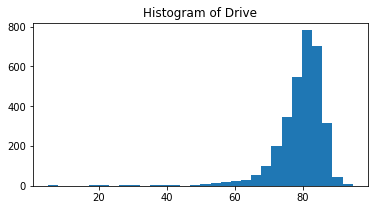

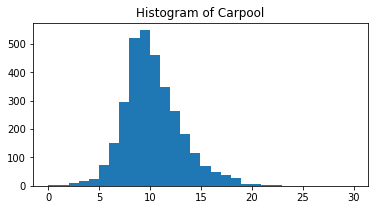

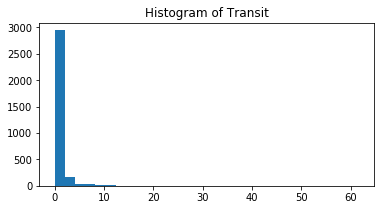

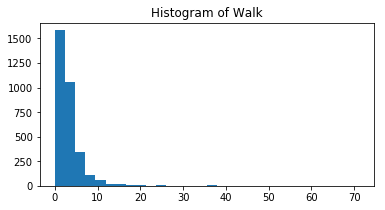

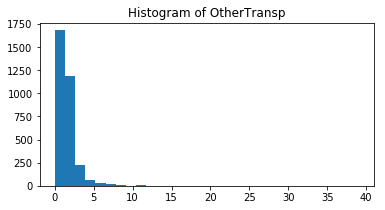

In [14]:
# transportation (to work)
transport_list = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']
n_bins = 30 # can decrease to get a wider bin (or vice versa)

for column_name in transport_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(clean_counties_df[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

### 练习：创建你自己的直方图

通勤方法是一种特征类别。如果你查看 34 个特征，可以看到职业、种族、收入等数据。请创建你感兴趣的直方图。


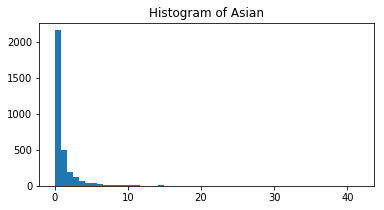

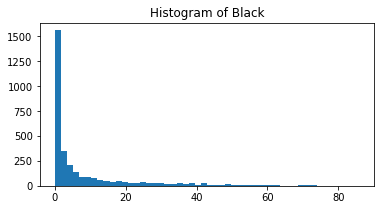

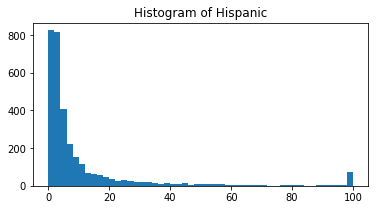

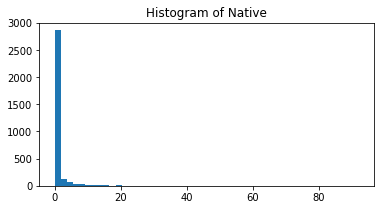

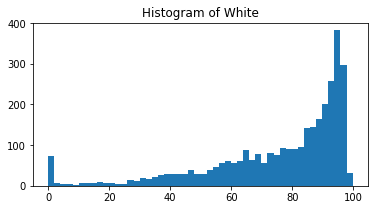

In [15]:
# create a list of features that you want to compare or examine
my_list = ["Asian", "Black", "Hispanic", "Native", "White"]
n_bins = 50 # define n_bins

# histogram creation code is similar to above
for column_name in my_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(clean_counties_df[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

### 练习：归一化数据

你需要归一化数值列的范围，从而一致地比较不同特征的值。你可以使用 [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) 转换数值，使其都位于 0-1 之间。 

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [17]:
# scale numerical features into a normalized range, 0-1
# store them in this dataframe
clean_counties_df_norm = scaler.fit_transform(clean_counties_df.astype(float))


In [18]:
clean_counties_df_norm = pd.DataFrame(clean_counties_df_norm, columns = clean_counties_df.columns, index = clean_counties_df.index)
clean_counties_df_norm.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,...,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,...,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,...,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192
Alabama-Bibb,0.002225,0.002414,0.002042,0.022022,0.746493,0.249127,0.004343,0.002404,0.0,0.002860,...,0.008427,0.038363,0.018817,0.611253,0.001754,0.804422,0.170530,0.183060,0.040816,0.227397
Alabama-Blount,0.005722,0.005738,0.005707,0.086086,0.880762,0.017462,0.003257,0.002404,0.0,0.006970,...,0.012640,0.010230,0.061828,0.767263,0.004751,0.892857,0.127483,0.114754,0.040816,0.210959


---
# 数据建模


现在，数据可以传入机器学习模型中了。

每个数据点都有 34 个特征，表明数据是 34 维的。聚类算法是指在 n 维特征空间里找到聚类。对于更高维的空间，k 均值等算法很难判断哪些特征最重要，生成的聚类通常更有噪点。

某些维度的重要性不如其他维度。例如，如果每个县的失业率都一样，那么这个特征就不能提供特别的信息；它不能帮助我们将郡县分成不同的组，因为每个县的失业率没有变化。

> 我们希望找到能够帮助分组数据的特征，即找到使数据集变化最大的特征。

所以在聚类数据之前，我将执行降维步骤。我的目标是创建更小的特征集，更好地帮助我们划分数据。我将用到**主成分分析** (PCA) 技巧。

## 降维

PCA 会降低数据集中的特征数量，同时保留“主成分”，定义为现有特征的加权线性组合，这些特征线性独立，并且可以解释数据中的最大潜在变化。可以将此方法看作获取很多特征，然后将相似或多余的特征组合到一起，形成新的更小型特征集。

我们可以使用内置的 PCA SageMaker 模型降维。

### 角色和存储桶

> 为了创建模型，首先需要指定 IAM 角色，为了保存模型属性，需要将属性存储到 S3 存储桶中。

`get_execution_role` 函数可以检索你在创建 notebook 实例时创建的 IAM 角色。这些角色将用来管理权限，详情请参阅[此文档](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html)。暂时只需记住我们有一个 FullAccess notebook，使我们能够访问和下载存储在 S3 中的人口普查数据。

必须在帐户中指定一个 S3 存储桶名称，该存储桶将用于存储 SageMaker 模型参数。注意，该存储桶必须与此 notebook 所在的区域一样。你可以通过存储当前 SageMaker 会话并调用 `session.default_bucket()`，获得默认 S3 存储桶，它会在你所在的区域为你自动创建一个存储桶。

In [19]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::270372225889:role/service-role/AmazonSageMaker-ExecutionRole-20200413T203959


In [20]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-west-2-270372225889



## 定义 PCA 模型

我将使用内置的 SageMaker 资源创建 PCA 模型。SageMaker 评估器要求指定多个参数：这些参数定义了训练实例的类型以及模型超参数。PCA 模型需要以下构造函数参数：

* role：IAM 角色，我们在上面指定了。
* train_instance_count：训练实例的数量（通常为 1）。
* train_instance_type：SageMaker 训练实例的类型。
* num_components：一个整数，指定要生成多少个 PCA 成分。
* sagemaker_session：在 SageMaker 上训练时用到的会话。

[这是](http://sagemaker.readthedocs.io/en/latest/pca.html) PCA 模型的参考文档。

下面我首先指定了训练数据的存储位置 `output_path`。

In [21]:
# define location to store model artifacts
prefix = 'counties'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-west-2-270372225889/counties/


In [22]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=33

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


### 将数据转换成 RecordSet 格式

接下来，将 DataFrame 转换成浮点型 NumPy 数组，为内置模型准备好数据。

SageMaker PCA 模型中的 *record_set* 函数会将 NumPy 数组转换成 **RecordSet** 格式，这是训练输入数据所要求的格式。所有 SageMaker 内置模型都要求输入数据是 RecordSet 格式。使用此类数据是在 Amazon SageMaker 中训练模型时速度很快的原因之一，尤其是对于大型数据集来说。

In [23]:
counties_scaled = clean_counties_df_norm

In [24]:
# convert df to np array
train_data_np = counties_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

## 训练模型

对 PCA 模型调用 fit 函数，传入特殊格式的训练数据。这样会启动训练实例来执行训练作业。

注意，启动指定的训练实例用时最长，拟合本身并不需要太长时间。

In [ ]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

2020-04-16 12:05:18 Starting - Starting the training job...
2020-04-16 12:05:19 Starting - Launching requested ML instances..
2020-04-16 12:06:20 Starting - Preparing the instances for training......
2020-04-16 12:07:42 Downloading - Downloading input data
2020-04-16 12:07:42 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/16/2020 12:07:58 INFO 140398654437184] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[04/16/2020 12:07:58 INFO 140398654437184] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'34', u'mini_batch_size': u'500', u'num_components': u'3


2020-04-16 12:08:07 Uploading - Uploading generated training model
2020-04-16 12:08:07 Completed - Training job completed
Training seconds: 38
Billable seconds: 38
CPU times: user 431 ms, sys: 14.7 ms, total: 446 ms
Wall time: 3min 11s


## 访问 PCA 模型属性

训练模型后，我们可以访问底层的模型参数。

### 解压缩模型工件

训练作业运行完毕后，你可以转到 Amazon SageMaker 控制台，在 **Jobs** 的 **Training** 部分找到训练作业。你可以在训练作业中找到列出的作业名称。请在以下代码中使用该作业名称指定要检查哪个模型。

模型工件以 TAR 文件形式存储在 S3 上；这是一个压缩文件，位于我们指定的输出路径 + 'output/model.tar.gz'。存储在这里的工件可以用来部署训练过的模型。

In [25]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console

training_job_name='pca-2020-04-15-13-19-51-881'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

counties/pca-2020-04-15-13-19-51-881/output/model.tar.gz


2304

### MXNet 数组

很多 Amazon SageMaker 算法都使用 MXNet 加快计算速度，包括 PCA 模型，所以模型工件存储为数组。解压缩模型后，我们可以使用 MXNet 加载该数组。

[这是](https://aws.amazon.com/mxnet/) MXNet 的参考文档。

In [26]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[1.7896362e-02 3.0864021e-02 3.2130770e-02 3.5486195e-02 9.4831578e-02
 1.2699370e-01 4.0288666e-01 1.4084760e+00 1.5100485e+00 1.5957943e+00
 1.7783760e+00 2.1662524e+00 2.2966361e+00 2.3856051e+00 2.6954880e+00
 2.8067985e+00 3.0175958e+00 3.3952675e+00 3.5731301e+00 3.6966958e+00
 4.1890211e+00 4.3457499e+00 4.5410376e+00 5.0189657e+00 5.5786467e+00
 5.9809699e+00 6.3925138e+00 7.6952214e+00 7.9913125e+00 1.0180052e+01
 1.1718245e+01 1.3035975e+01 1.9592180e+01]
<NDArray 33 @cpu(0)>, 'v': 
[[ 2.46869749e-03  2.56468095e-02  2.50773830e-03 ... -7.63925165e-02
   1.59879066e-02  5.04589686e-03]
 [-2.80601848e-02 -6.86634064e-01 -1.96283013e-02 ... -7.59587288e-02
   1.57304872e-02  4.95312130e-03]
 [ 3.25766727e-02  7.17300594e-01  2.40726061e-02 ... -7.68136829e-02
   1.62378680e-02  5.13597298e-03]
 ...
 [ 1.12151138e-01 -1.17030945e-02 -2.88011521e-01 ...  1.39890045e-01
  -3.09406728e-01 -6.34506866e-02]
 [ 2.99992133e-02 -3.13433539e-03 -7.63589665e-02 ...  4.17341813e-02


## PCA 模型属性

PCA 模型包含三种类型的模型属性。

* **mean**：为了居中成分而使成分减去的均值。
* **v**：主成分的构成（与 sklearn PCA 模型中的“components_”一样）。
* **s**：PCA 转换的成分奇异值。并不表示原始特征空间的精确方差百分比，但是可以表示投射特征空间的方差百分比。
    
我们只对 v 和 s 感兴趣。

我们可以通过 s 获得前 `n` 个主成分能解释的数据方差近似百分比。近似解释方差的公式为：前 n 个成分的平方 s 值除以所有成分的平方 s 值：

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

我们可以通过 v 了解每个主成分的原始特征组成。


In [27]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

## 数据方差

当前 PCA 模型会创建 33 个主成分，但是当我们创建新的降维训练数据时，我们将仅选择几个主成分。为了判断应该使用多少个主成分，有必要查看这些成分能解释的**数据方差**。对于我们的原始高维数据，34 个特征可以解释所有的数据方差。如果我们丢弃某些维度，能够解释的方差量将减少。

### 权衡：维数与数据方差

举个例子，假设原始数据是三维的。所以三个维度可以解释所有的数据方差；这些维度涵盖了数据的整个分散空间。下图来自博士论文 [“Approaches to analyse and interpret biological profile data”](https://publishup.uni-potsdam.de/opus4-ubp/frontdoor/index/index/docId/696)，作者：Matthias Scholz（2006 年，德国波茨坦大学）。

<img src='notebook_ims/3d_original_data.png' width=35% />

你可能还发现，大多数数据都有关联；靠近一个二维平面，通过查看数据的分散状况，可以看出原始三维数据具有某种关联性。所以我们可以创建新的二维数据，是原始三个维度的线性组合。这些维度由数据中居中的两个轴/两条线表示。

<img src='notebook_ims/pca_2d_dim_reduction.png' width=70% />

如果将数据投射到这个新的二维平面上，可以看出仅使用两个维度依然能解释大部分原始数据中的方差。我们需要在能解释的方差量与表示数据用到的成分/维度数量之间做出权衡。

在选择用于新数据模型的前 n 个成分时，我们通常希望包含足够多的成分，能够解释约 80-90% 的原始数据方差。在此项目中，我们希望能在很多数据上进行泛化并解释约 80% 的方差。

**注意：**s 值最大的靠前主成分实际上位于 s DataFrame 的末尾。我们输出前 n 个主成分的 s 值。

In [28]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])

            0
28   7.991313
29  10.180052
30  11.718245
31  13.035975
32  19.592180


### 练习：计算解释的方差

在创建新的训练数据时，你需要选择能够解释至少 80% 数据方差的前 n 个主成分。

请完成函数 `explained_variance`，它的参数包括整个数组 `s` 以及靠前主成分的数量。然后返回前 n 个成分解释的近似方差量。

例如，为了计算前 5 个成分解释的方差，需要根据以下公式计算前 5 个成分中每个成分的 s 平分，将这些平方相加，然后除以所有 s 值的平方和：

\begin{equation*}
\frac{\sum_{5}^{ } s_n^2}{\sum s^2}
\end{equation*}

> 完成此函数后，你应该能够回答**问题**：能够解释至少 80% 数据方差的最少主成分数量是多少？

In [29]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    # your code here
    start_idx = N_COMPONENTS - n_top_components
    
    exp_variance = np.square(s.iloc[start_idx:, :]).sum()/np.square(s).sum()
    
    return exp_variance[0]


### 测试单元格

通过查看你的代码对不同输入的响应情况测试代码；对于最高的主成分，它能够返回合理的值吗？对于前 5 个主成分，能返回合理的值吗？

In [30]:
# test cell
n_top_components = 7 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.80167246


例如，最高主成分应该能解释约 32% 的数据方差。接下来，你可能会疑问这个主成分（以及其他成分）是如何组成的；什么样的特征线性组合使这些成分对于描述数据分散性如此有影响？

下面看看原始特征，并在后面进行参考。

In [31]:
# features
features_list = counties_scaled.columns.values
print('Features: \n', features_list)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


## 成分组成

我们现在可以根据**原始特征在成分中的权重**，了解每个 PCA 成分的组成。以下代码显示了第一个成分的特征集组成。

注意，成分按从小到大的顺序排序，我可以调用 N_COMPONENTS-1 获得第一个成分所在的行。

In [32]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


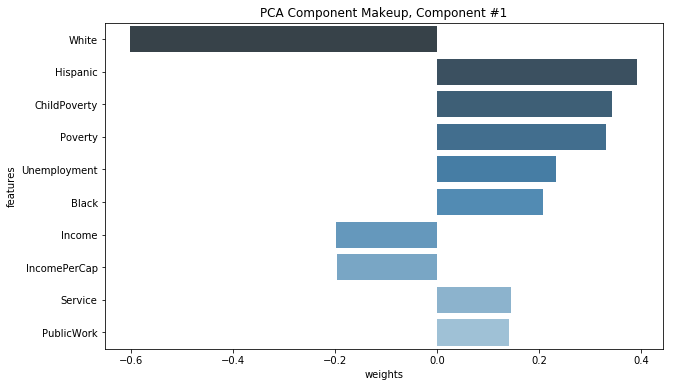

In [33]:
# display makeup of first component
num=1
display_component(v, counties_scaled.columns.values, component_num=num, n_weights=10)

# 部署 PCA 模型

我们现在可以部署该模型并用它做出预测。现在我们并不查看测试数据的运行结果，而是将训练数据传入部署的端点中，并为每个数据点创建主成分。

请运行以下单元格，将此模型部署/托管到指定类型的实例上。

In [36]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

---------------!CPU times: user 278 ms, sys: 21.8 ms, total: 300 ms
Wall time: 7min 32s


我们可以将原始 NumPy 数据集传递给模型，并使用我们创建的模型转换数据。然后使用前 n 个成分降低数据的维度。

In [37]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

In [38]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.0002009272575378418
      values: 0.0002455431967973709
      values: -0.0005782842636108398
      values: -0.0007815659046173096
      values: -0.00041911262087523937
      values: -0.0005133943632245064
      values: -0.0011316537857055664
      values: 0.0017268601804971695
      values: -0.005361668765544891
      values: -0.009066537022590637
      values: -0.008141040802001953
      values: -0.004735097289085388
      values: -0.00716288760304451
      values: 0.0003725700080394745
      values: -0.01208949089050293
      values: 0.02134685218334198
      values: 0.0009293854236602783
      values: 0.002417147159576416
      values: -0.0034637749195098877
      values: 0.01794189214706421
      values: -0.01639425754547119
      values: 0.06260128319263458
      values: 0.06637358665466309
      values: 0.002479255199432373
      values: 0.10011336207389832
      values: -0.1136140376329422
      values: 0

### 练习：创建转换过的 DataFrame

对于每个数据点，从上述预测器返回的成分数据点列表中获取前 n 个成分值，并将这些值放入新的 DataFrame 中。

生成的 DataFrame 应该如下所示：
```
                     c_1	     c_2	       c_3	       c_4	      c_5	   ...
Alabama-Autauga	-0.060274	0.160527	-0.088356	 0.120480	-0.010824	...
Alabama-Baldwin	-0.149684	0.185969	-0.145743	-0.023092	-0.068677	...
Alabama-Barbour	0.506202	 0.296662	 0.146258	 0.297829	0.093111	...
...
```

In [60]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, counties_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create a dataframe of component features, indexed by State-County
    conties_transformed = pd.DataFrame()
    
    for data in train_pca:
        components = data.label['projection'].float32_tensor.values
        conties_transformed = conties_transformed.append([list(components)])
        
    conties_transformed.index = counties_scaled.index
    
    # your code here
    conties_transformed = conties_transformed.iloc[:,-n_top_components:]
    
    return conties_transformed.iloc[:,::-1]


现在我们可以创建一个数据集，其中的每个郡县都由之前分析过的前 n 个主成分描述。每个成分都是原始特征空间的线性组合。我们可以通过分析这些成分的组成（之前演示过）解释每个成分。

### 定义要在此转换后数据中使用的 `top_n` 成分

代码应该返回数据，按照“State-County”设定索引并且列数与 `top_n` 成分的数量一样。

还可以选择为数据添加描述性列名；名称与成分编号或特征级组成相对应。

In [61]:
## Specify top n
top_n = 7

# call your function and create a new dataframe
counties_transformed = create_transformed_df(train_pca, counties_scaled, n_top_components=top_n)

## TODO: Add descriptive column names
columns = ['C-1', 'C-2', 'C-3', 'C-4', 'C-5', 'C-6', 'C-7']

counties_transformed.columns = columns

# print result
counties_transformed.head()

,C-1,C-2,C-3,C-4,C-5,C-6,C-7
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137
Alabama-Barbour,0.506202,0.296662,0.146258,0.297829,0.093111,-0.065244,0.107730
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099


### 删除端点！

我们已经部署了模型并创建了新的格式化训练数据，不再需要 PCA 端点了。

在清理步骤，在使用完端点（以及不打算部署到网站）后，始终都要删除端点。

In [62]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

---
# 人口分割

下面使用非监督式聚类算法 k 均值并根据 PCA 属性分割郡县，这些郡县数据是我们刚刚创建的格式 DataFrame。k 均值是一个聚类算法，可以根据成分组成识别相似数据点聚类。因为原始数据集有约 3000 个郡县和 34 个属性，这么庞大的特征空间使我们难以有效聚类郡县。所以我们将特征空间缩小成 7 个 PCA 成分，并根据这一格式化数据集聚类数据点。

### 练习：定义 k 均值模型

你的任务是实例化一个 K 均值模型。`KMeans` 需要实例化多个参数，包括指定训练实例的类型，以及模型超参数。

要了解所需的参数，请参阅 [`KMeans` 文档](https://sagemaker.readthedocs.io/en/stable/kmeans.html)；注意，并非所有的参数都必须设置。


### 选择“好的”K

选择“好的”K 的一种方法是，根据经验数据选择 k。糟糕的 k 值可能是值太高，导致形心附近只有一两个非常接近的数据点；另一种糟糕的 k 是太低，数据点离形心很远。

选择的 k 值应该能保证：单个聚类中的数据点很相似，但是有足够的聚类可以有效区分数据。你可以测量数据点与每个形心的距离、聚类数据点与形心之间的平均距离，然后逼近这种划分值。尝试了多个 k 值后，形心距离通常会达到某种“肘部”效果；距离停止以很高的速率下降，这时候的 k 值就是很合适的 k 值。下图演示了 k 值在 5 到 12 之间时，成分数据与形心之间的平均距离。

<img src='notebook_ims/elbow_graph.png' width=50% />

在 8 左右出现了肘部效果的距离，距离开始增大，然后开始以更低的速度下降。表明我们能够足够地区分每个聚类中的数据点，并且包含的聚类足够多，使数据点距离每个聚类不是太远。

In [64]:
from sagemaker import KMeans

In [65]:
# define a KMeans estimator
KMestimator = KMeans(role=role,
                     train_instance_count=1,
                     train_instance_type='ml.c4.xlarge',
                     output_path=output_path, # specified, above
                    sagemaker_session=session,
                    k=8)

### 练习：创建特殊格式的 k 均值训练数据

与之前一样，你应该将 `counties_transformed` dataframe 转换成 numpy 数组，然后转换成 RecordSet。RecordSet 是 `KMeans` 模型要求的训练数据输入格式。

In [66]:
# convert the transformed dataframe into record_set data
# convert df to np array
counties_transformed_np = counties_transformed.values.astype('float32')

# convert to RecordSet format
counties_transformed_np_formatted_train_data = KMestimator.record_set(counties_transformed_np)

### 练习：训练 k 均值模型

传入特殊格式的训练数据并训练 k 均值模型。

In [67]:
%%time
# train kmeans
KMestimator.fit(counties_transformed_np_formatted_train_data)

2020-04-16 12:43:56 Starting - Starting the training job...
2020-04-16 12:43:58 Starting - Launching requested ML instances......
2020-04-16 12:45:03 Starting - Preparing the instances for training......
2020-04-16 12:46:21 Downloading - Downloading input data...
2020-04-16 12:46:39 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/16/2020 12:47:02 INFO 140689258751808] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'ev


2020-04-16 12:47:11 Uploading - Uploading generated training model
2020-04-16 12:47:11 Completed - Training job completed
Training seconds: 50
Billable seconds: 50
CPU times: user 472 ms, sys: 24.8 ms, total: 497 ms
Wall time: 3min 42s


### 练习：部署 k 均值模型

部署训练过的模型以创建 `kmeans_predictor`。


In [68]:
%%time
# deploy the model to create a predictor
kmeans_predictor = KMestimator.deploy(initial_instance_count=1,
                                     instance_type='ml.c4.xlarge')

-------------!CPU times: user 257 ms, sys: 4.75 ms, total: 262 ms
Wall time: 6min 31s


### 练习：传入训练数据并分配预测的聚类标签

部署模型后，你可以传入 numpy 数组形式的 k 均值训练数据，并获得每个数据点的预测聚类标签。

In [69]:
# get the predicted clusters for all the kmeans training data
cluster_info=kmeans_predictor.predict(counties_transformed_np)

## 探索生成的聚类

生成的预测可以告诉你每个数据点属于哪个聚类。

你应该能够回答**问题**：给定数据点属于哪个聚类？

In [70]:
# print cluster info for first data point
data_idx = 0

print('County is: ', counties_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

County is:  Alabama-Autauga

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 3.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.2959037125110626
    }
  }
}



### 可视化聚类的数据分布

获取每个数据点（郡县）的聚类标签，并可视化每个聚类的数据点分布。

In [71]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

In [72]:
# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

3.0    1079
0.0     528
5.0     452
6.0     443
1.0     235
7.0     196
2.0     194
4.0      91
Name: 0, dtype: int64


现在你可能会疑问，每个聚类可以展示什么样的数据点信息？为了便于解释数据，我们需要访问底层模型并获得形心。形心可以告诉我们哪些特征描述了每个聚类。

### 删除端点！

开发了 k 均值模型并获得了每个数据点的聚类标签后，你不再需要 k 均值端点了。

In [73]:
# delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

---
# 模型属性和可解释性

解释模型结果是利用分析数据的重要步骤。通过 PCA 和 K 均值以及 SageMaker 已训练模型中包含的模型属性信息，你可以了解人口并描述根据数据发现的模式。

### 练习：访问 k 均值模型属性

从存储在 S3 存储桶中的 TAR 文件里提取 k 均值模型属性。

你需要根据 k 均值训练作业名称访问模型，然后将文件解压缩到 model_algo-1 中。

In [74]:
# download and unzip the kmeans model file
# use the name model_algo-1
training_job_name='kmeans-2020-04-16-12-43-56-604'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

counties/kmeans-2020-04-16-12-43-56-604/output/model.tar.gz


2304

In [75]:
# get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

[
[[-0.24778093 -0.10617565  0.01425313 -0.01821043  0.00320397 -0.03176168
   0.00305689]
 [ 0.11454032 -0.2789913   0.07017624  0.08507644 -0.05920428 -0.029167
  -0.10089773]
 [ 0.35877147 -0.18583804 -0.16937783 -0.19527806  0.12678142 -0.13652176
  -0.08454256]
 [-0.10059994  0.1146465   0.10630932 -0.0875468  -0.03636129  0.02767255
  -0.01703247]
 [ 1.293383   -0.24214679 -0.1619557  -0.39616823 -0.12349369  0.11457874
   0.1261519 ]
 [-0.19593759  0.07931182 -0.32409132  0.03703118 -0.0304271   0.05320958
   0.0053954 ]
 [ 0.3034642   0.21551989  0.04387958  0.23604389  0.076451   -0.04008155
   0.03720205]
 [-0.28150302 -0.46341434  0.11842921  0.11652972  0.09112835  0.03398459
   0.14119111]]
<NDArray 8x7 @cpu(0)>]


k 均值模型中只有 1 组模型参数：形心在 PCA 转换成分空间里的位置。

* **形心**：由 k 均值算法确定的每个形心在成分空间里的中心位置。


In [76]:
# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns=counties_transformed.columns

display(cluster_centroids)

,C-1,C-2,C-3,C-4,C-5,C-6,C-7
0,-0.247781,-0.106176,0.014253,-0.018210,0.003204,-0.031762,0.003057
1,0.114540,-0.278991,0.070176,0.085076,-0.059204,-0.029167,-0.100898
2,0.358771,-0.185838,-0.169378,-0.195278,0.126781,-0.136522,-0.084543
3,-0.100600,0.114647,0.106309,-0.087547,-0.036361,0.027673,-0.017032
4,1.293383,-0.242147,-0.161956,-0.396168,-0.123494,0.114579,0.126152
5,-0.195938,0.079312,-0.324091,0.037031,-0.030427,0.053210,0.005395
6,0.303464,0.215520,0.043880,0.236044,0.076451,-0.040082,0.037202
7,-0.281503,-0.463414,0.118429,0.116530,0.091128,0.033985,0.141191


### 可视化成分空间里的形心

你无法可视化 7 维形心，但是可以绘制形心以及形心在转换后特征空间里的位置的热图。

这样就可以判断每个聚类是由哪些特征组成的。通常，对于非监督式学习来说，结果都比较难解释。这是利用 PCA 和聚类技巧的一种方式。因为能够查看每个 PCA 成分的组成，所以知道从 PCA 成分的角度来说，每个形心代表什么。

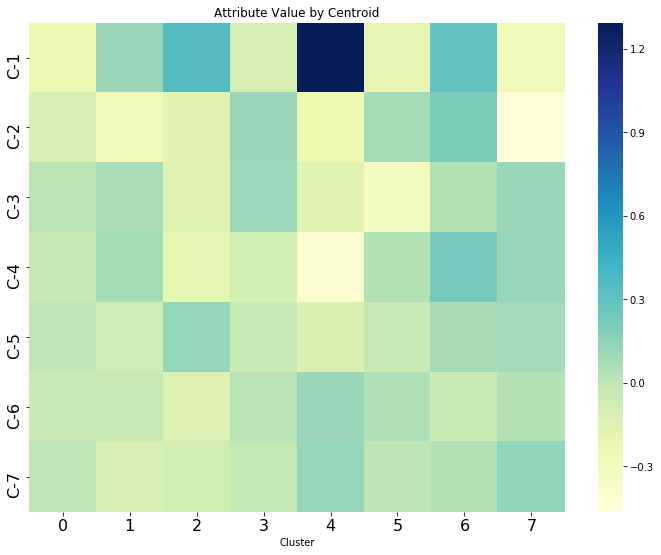

In [77]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

如果你忘记每个成分由哪些原始特征组成，也没关系。可以通过之前定义的 `display_component` 函数查看特征级组成。

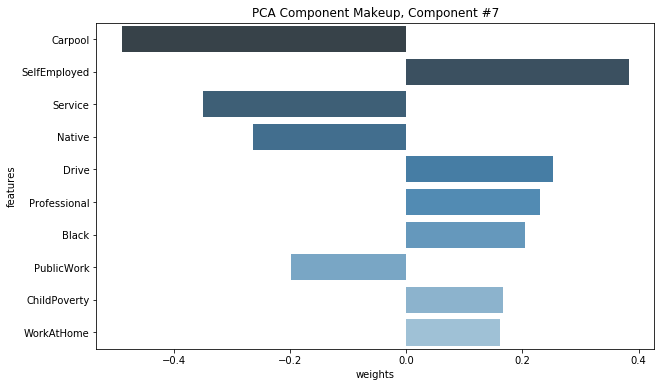

In [78]:
# what do each of these components mean again?
# let's use the display function, from above
component_num=7
display_component(v, counties_scaled.columns.values, component_num=component_num)

### 自然分组

你还可以将聚类标签映射到每个郡县，并查看哪些郡县会自然分组到一起。

In [79]:
# add a 'labels' column to the dataframe
counties_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_counties = counties_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_counties.head(20)

,C-1,C-2,C-3,C-4,C-5,C-6,C-7,labels
Missouri-Caldwell,-0.223024,-0.034671,0.110380,-0.045907,0.115372,0.271728,-0.007824,0
Kansas-Jackson,-0.207493,-0.141456,0.031607,0.034517,0.065709,0.068088,-0.159441,0
Kansas-Jefferson,-0.292094,0.025811,-0.043092,-0.027886,0.032327,0.175967,-0.076776,0
Oklahoma-Major,-0.206359,-0.074993,0.016422,-0.094563,0.070316,-0.022189,0.137489,0
Kansas-Kingman,-0.308608,-0.178351,0.103926,-0.032880,0.102060,0.015712,0.118374,0
Oklahoma-McClain,-0.185889,-0.080475,-0.109745,-0.000475,0.024557,0.115287,0.010291,0
Kansas-Linn,-0.251154,0.001746,0.030032,-0.041137,0.103551,0.277581,0.009228,0
Kansas-McPherson,-0.386262,-0.066217,-0.045728,-0.034233,-0.031885,-0.244105,0.019713,0
Kansas-Marion,-0.279349,-0.078723,0.071350,-0.034699,-0.048933,-0.083104,0.010498,0
Kansas-Marshall,-0.322540,-0.070455,0.096539,-0.061422,-0.041117,-0.202742,0.050424,0


还可以仔细检查某个聚类，例如聚类 1。快速查看下形心在成分空间（热图）里的位置可以判断，它对应于 `comp_6` 属性的值最高。你可以看看哪些郡县满足这一条件。

In [80]:
# get all counties with label == 1
cluster=counties_transformed[counties_transformed['labels']==1]
cluster.head()

,C-1,C-2,C-3,C-4,C-5,C-6,C-7,labels
Alaska-Bethel Census Area,0.597473,-0.624618,-0.048797,0.572906,-0.430761,-0.239015,-0.684414,1
Alaska-Bristol Bay Borough,-0.076956,-0.697145,-0.096949,0.375183,0.117681,-0.159489,-0.342943,1
Alaska-Dillingham Census Area,0.392701,-0.579860,-0.126503,0.466510,-0.226094,-0.250855,-0.580714,1
Alaska-Hoonah-Angoon Census Area,0.105957,-0.765696,0.092466,0.429462,-0.010597,-0.169204,-0.224622,1
Alaska-Juneau City and Borough,-0.185123,-0.487067,-0.323975,0.346200,-0.051802,-0.005061,-0.252171,1


## 最后清理步骤！

* 仔细检查是否删除了所有端点。
* 还建议直接在 AWS 控制台中手动删除 S3 存储桶、模型和端点配置。

[这篇文档](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html)详细介绍了清理步骤。

---
# 总结

你刚刚已经完成了非监督式学习的机器学习工作流程，即在使用 PCA 降维后，使用 k 均值聚类数据集。通过访问在 SageMaker 中创建的底层模型，你能够提高模型的解释能力，并根据生成的聚类得出结论。

利用这些计数，你能够更好地了解美国不同郡县的特性，并根据相似性对它们分组。